In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as random

In [2]:
data = pd.read_csv("posnerData_S2.txt", sep="\t")
data.head()

,TN,Cue,Valid,Reaction Time,Correct
0,1,L,T,0.240664,T
1,2,L,F,0.364819,T
2,3,R,F,0.228003,T
3,4,R,T,0.249184,T
4,5,L,T,0.195587,T


### Dataset Information for Subject 1

In [3]:
print(data.shape)
print(data.info())
print(data.describe())

(200, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TN             200 non-null    int64  
 1   Cue            200 non-null    object 
 2   Valid          200 non-null    object 
 3   Reaction Time  200 non-null    float64
 4   Correct        200 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 7.9+ KB
None
               TN  Reaction Time
count  200.000000     200.000000
mean   100.500000       0.301910
std     57.879185       0.079829
min      1.000000       0.183314
25%     50.750000       0.248808
50%    100.500000       0.280103
75%    150.250000       0.343018
max    200.000000       0.760668


In [4]:
data["Correct"].unique()

array(['T', 'F'], dtype=object)

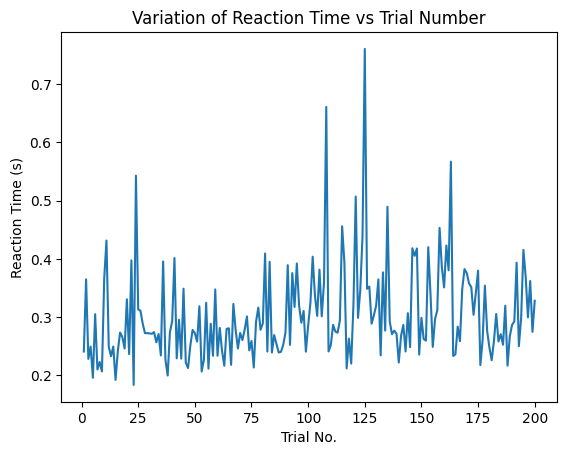

In [5]:
plt.plot(data["TN"], data["Reaction Time"])
plt.title("Variation of Reaction Time vs Trial Number")
plt.xlabel("Trial No.")
plt.ylabel("Reaction Time (s)")
plt.show()

In [6]:
# Filter correct responses
correct_cue_data = data[data['Correct'] == 'T']

# Summarize statistics for valid and invalid cues
summary = correct_cue_data.groupby('Valid').agg(
    mean_rt=('Reaction Time', 'mean'),
    rt_variance=('Reaction Time', 'var'),
    accuracy=('Correct', 'count')  # Proportion correct needs all trials
).reset_index()

type(summary)
summary.head()

,Valid,mean_rt,rt_variance,accuracy
0,F,0.292183,0.005770,53
1,T,0.306985,0.006569,144


In [7]:
total_trials = data.groupby('Valid')['TN'].count().reset_index() #.rename(columns={'TN': 'total_trials'})
summary = summary.merge(total_trials, on='Valid')
summary['accuracy'] = summary['accuracy'] / summary['TN']

### Old Model Method from Wagen-something paper

In [8]:
def wagen_ez_diffusion(mean_rt, rt_variance, accuracy):
    s = 0.1  # Standard deviation of drift rate

    if accuracy >= 1.0:
        accuracy = 0.999
    elif accuracy <= 0.0:
        accuracy = 0.001

    L = np.log(accuracy / (1 - accuracy))
    x = ((L * (L * accuracy * (1 - accuracy) - rt_variance * s**2))**0.5) / (rt_variance * s**2)
    drift_rate = x * s
    boundary_separation = L / drift_rate
    non_decision_time = mean_rt - (boundary_separation / (2 * drift_rate))
    return drift_rate, boundary_separation, non_decision_time

In [9]:
# Apply EZ-diffusion model for each condition
for _, row in summary.iterrows():
    v, a, Ter = wagen_ez_diffusion(row['mean_rt'], row['rt_variance'], row['accuracy'])
    print(f"Condition: {'Valid' if row['Valid'] == 'T' else 'Invalid'}")
    print(f"  Drift Rate (v): {v:.4f}")
    print(f"  Boundary Separation (a): {a:.4f}")
    print(f"  Non-Decision Time (Ter): {Ter:.4f} seconds\n")

Condition: Invalid
  Drift Rate (v): 927.3097
  Boundary Separation (a): 0.0043
  Non-Decision Time (Ter): 0.2922 seconds

Condition: Valid
  Drift Rate (v): 756.2733
  Boundary Separation (a): 0.0057
  Non-Decision Time (Ter): 0.3070 seconds



## Model Equations from textbook

In [10]:
def ez_diffusion_model_v2(accuracy, rt_mean, rt_variance, scaling_param=0.1):
    """
    Calculate the drift rate (v) and boundary separation (a) for the EZ-diffusion model.

    Parameters:
    - accuracy: Probability of correct responses (P_c).
    - rt_mean: Mean reaction time for correct responses.
    - rt_variance: Variance of reaction times for correct responses.
    - scaling_param: Scaling parameter (s), default is 0.1.

    Returns:
    - drift_rate (v)
    - boundary_separation (a)
    - non_decision_time (Ter)
    """
    
    if accuracy <= 0 or accuracy >= 1:
        raise ValueError("Accuracy must be between 0 and 1 (exclusive).")
    if rt_variance <= 0:
        raise ValueError("RT variance must be positive.")

    logit_pc = np.log(accuracy / (1 - accuracy))

    # Drift rate (v)
    drift_rate = (
        np.sign(accuracy - 0.5)
        * scaling_param
        * np.sqrt(
            (logit_pc * (accuracy**2 * logit_pc - accuracy * logit_pc + accuracy - 0.5)) / rt_variance
        )
    )

    # Boundary separation (a)
    boundary_separation = (scaling_param**2 * logit_pc) / drift_rate

    # Non-decision time (Ter)
    non_decision_time = rt_mean - (boundary_separation / (2 * drift_rate))

    return drift_rate, boundary_separation, non_decision_time


In [11]:
print(summary['accuracy'])

0    0.981481
1    0.986301
Name: accuracy, dtype: float64


In [12]:
invalid_accuracy = summary[(summary['accuracy'] <= 0) | (summary['accuracy'] >= 1)]
print("Rows with invalid accuracy values:")
print(invalid_accuracy)

Rows with invalid accuracy values:
Empty DataFrame
Columns: [Valid, mean_rt, rt_variance, accuracy, TN]
Index: []


In [13]:
# Apply EZ-diffusion model for each condition using ez_diffusion_model_v2
for _, row in summary.iterrows():
    v, a, Ter = ez_diffusion_model_v2(row['accuracy'], row['mean_rt'], row['rt_variance'])  # Updated function call
    print(f"Condition: {'Valid' if row['Valid'] == 'T' else 'Invalid'}")
    print(f"  Drift Rate (v): {v:.4f}")
    print(f"  Boundary Separation (a): {a:.4f}")
    print(f"  Non-Decision Time (Ter): {Ter:.4f} seconds\n")

Condition: Invalid
  Drift Rate (v): 1.6783
  Boundary Separation (a): 0.0237
  Non-Decision Time (Ter): 0.2851 seconds

Condition: Valid
  Drift Rate (v): 1.6702
  Boundary Separation (a): 0.0256
  Non-Decision Time (Ter): 0.2993 seconds

